In [36]:
"""LiuKatrina_06.ipynb Harvard MCB 112 Problem Set 08: the cycle of twelve submitted by Xiao (Katrina) Liu"""
__author__      = "Katrina Liu"
__email__ = "xliu@hms.harvard.edu"
__date__ = "Oct 25, 2022"

In [37]:
import pandas as pd
import numpy as np
import math
import re
import scipy.optimize as optimize
import scipy.stats    as stats
import os
import matplotlib.pyplot as plt

# Exercise 1: Solve by maximum likelihood
Before the analysis, we need to read the data from the given data table.

In [38]:
def read_table(datafile):
    """
    Parse expression data from the provided file, code adopted from Moriarty's
    script on mcb112.org
    :param datafile: path to data table file
    :return: a list of time points, a list of sigmas, a list of gene names,
             a 2-D array of expression levels
    """
    with open(datafile) as f:
        # First header line gives us the time points
        fields = f.readline().split()
        X = []
        for s in fields:
            match = re.search(r'^(\d+)hr', s)
            X.append(int(match.group(1)))
        X = np.array(X)
        N = len(X)

        # Second header line gives us "gene" followed by +=SD's
        fields = f.readline().split()
        S_true = np.zeros(N)
        for i,s in enumerate(fields[1:]):
            match = re.search(r'^\+-(\d+)', s)
            S_true[i] = float(match.group(1))

        # Third header line is just ------ stuff
        f.readline()

        # Remaining lines are data
        genenames = []
        Y = []
        for line in f.readlines():
            fields = line.split()
            genenames.append(fields[0])
            Y.append( np.array( [ float(s) for s in fields[1:]] ))
        G = len(Y)
        return X, S_true, genenames, Y

In [39]:
# Reading w08-data.tbl
time_points, sigmas, gene_names, data = read_table("w08-data.tbl")

Based on the problem description, the cyclic expression of a gene is being described as following below pattern: 
$$y_t= b+a\sin(2\pi\omega(t+\phi))$$
where $b, a, \phi$ are determined by each model. However, since our data considers the standard deviations of the expressions, we need to take that into account of the expression level. So essentially, $$y_t = b+a\sin(2\pi\omega(t+\phi))+\epsilon, \epsilon \sim N(0, \sigma^2)$$ From this, we realize that $$residual = y_t-(b+a\sin(2\pi\omega(t+\phi)))\sim N(0, \sigma^2)$$ We are aiming to find the best paramters $b,a,\phi$ to fit the observed expression data to the cyclic model, so our objective would be to maximize the probability of observing the data given $b,a,\phi$, which is equivalent to minimizing the log likelihood:
$$\max_{b,a,\phi}P(Y|b,a,\phi) \Leftrightarrow \min_{b,a,\phi} -\log P(Y|b,a,\phi)$$
Let n be the number of experiments. We then go ahead and simplify $$P(Y|b,a,\phi) = \prod_{i=1}^n P(y_{i}|b,a,\phi,\sigma_i) = \prod_{i=1}^n P_{Gaussian}(y_{i}-(b+a\sin(2\pi\omega(t_i+\phi)))|0,\sigma_i^2)$$
If we take the log likelihood of that, we will have $$\log P(Y|b,a,\phi) = \sum_{i=1}^n \log P_{Gaussian}(y_{i}-(b+a\sin(2\pi\omega(t_i+\phi)))|0,\sigma_i^2)$$

In [40]:
def harmonic_nll(p,expr,sigma, time):
    """
    Calculate the negative log likelihood of observing expression with 
    the given parameters
    :param p: a 3-tuple of values for b, a, phi
    :param expr: a list of length N of expression values obtained from 
                each experiment
    :param sigma: a list of length N of sigma used in each experiment
    :param time: a list of length N if the time to collect the expression 
                for each experiment 
    :return: the negative log likelihood of the expression levels given 
            the experiment setup
    """
    ll = 0
    b, a, phi = p[0], p[1], p[2]
    for i in range(len(expr)):
        y = expr[i]
        t = time[i]
        mean = b + a*math.sin(2*math.pi*(t+phi)/24)
        residual = y - mean
        sd = sigma[i]
        ll += stats.norm.logpdf(residual,0,sd)
    return -ll


Once we have the function to calculate the negative log likelihood, we will be able to run the optmization with different initial values and pick the results obtained from the run with the lowest negative log likelihood. Parameter b and a shoud have a lower bound of 0 as they represents the initial expression level and the amptitude of expression level change over time. Parameter phi should be of range [0, 24] as it indicate the phases and our cycle is 24 hours.

In [41]:

def harmonic_mle(data, sigmas, time_points, iter = 20, bounds=[(0,None), (0,None), (0,24)],jac=None):
    """
    Perform maximum likelihood estimation for cyclic functions to fit observed
    data to model
    :param data: a 2D array of expression data with each row a gene, each 
                column an experiment
    :param sigmas: a list of standard deviation used in each experiments
    :param time_points: a list of time points each experiment collect its 
                        results
    :param iter: number of times the MLE run with different initial guess 
                parameters
    :param bounds: the bounds of paramters to provide to the 
                    scipy.optimize.minimize
    :param jac: jacobian function for the optimization
    :return: a 2D array of best value for paramters b, a, phi for each gene,
             a list of minimal negative log likelihood values for each gene
    """
    best_parameters = []
    best_objectives = []
    for i in range(len(data)):
        best_ps = None
        best_fun = None
        for _ in range(iter):
            expr = data[i]
            b_0 = np.random.uniform(0,100)
            a_0 = np.random.uniform(0,100)
            phi_0 = np.random.uniform(0,24)
            p0 = [b_0,a_0,phi_0]
            if jac is None:
                result = optimize.minimize(harmonic_nll,p0,(expr,sigmas,time_points), bounds=bounds)
            else:
                result = optimize.minimize(harmonic_nll,p0,(expr,sigmas,time_points), bounds=bounds,jac=jac)
            if result.success:
                if best_fun == None or best_fun>result.fun:
                    best_fun = result.fun
                    best_ps = result.x
        best_parameters.append(best_ps)
        best_objectives.append(best_fun)
    return np.array(best_parameters), np.array(best_objectives)


In [42]:
# Perform MLE on the data extracted from w08-data.tbl
res_params,res_ll = harmonic_mle(data, sigmas,time_points)
print(res_params)
print(res_ll)

[[39.99232232 22.41506702  0.44869211]
 [48.84038005 31.84256959 16.26464967]
 [47.57656466 24.23129712 21.41457006]
 [44.90180716 32.33376433 20.42018378]
 [42.75634857 22.14772669  2.77717696]
 [51.26473479 19.09948253  6.68728899]
 [48.01806791 27.59601675 10.15713965]
 [49.72587354 18.40096307 14.26508322]
 [40.85218172 30.61459548  7.42064691]
 [45.98601967 21.57750812 11.46567927]
 [53.0639752  17.32490808  3.48070498]
 [39.12346962 27.48068979 17.94545562]]
[26.70550396 24.81133362 25.73140051 24.48953586 25.74728525 27.0341362
 26.84959211 25.46110781 25.49206885 28.58834507 25.83039839 24.98893508]


## Gradiant of the objective
To save computational costs in our maximum likelihood estimation, we will calculate the gradient of our objective, which is the negative log likelihood of the parameters.
$$-\log P(Y|b,a,\phi) = -\sum_{i=1}^n \log P_{Gaussian}(y_{i}-(b+a\sin(2\pi\omega(t_i+\phi)))|0,\sigma_i^2)$$
We substitute the log PDF of the Gaussian distribution: $$\ln P_{Gaussian}(\mu,\sigma^2)=-\dfrac{(x-\mu)^2}{2\sigma^2}-\ln \sigma-\dfrac{1}{2}\ln (2\pi)$$
into the negative log likelihood, we will get:
$$f(b,a,\phi)=-\log P(Y|b,a,\phi)=-\sum_{i=1}^n (-\dfrac{(y_{i}-(b+a\sin(2\pi\omega(t_i+\phi))))^2}{2\sigma_i^2}-\ln \sigma_i-\dfrac{1}{2}\ln (2\pi))$$
$$=\sum_{i=1}^n (\dfrac{(y_{i}-(b+a\sin(2\pi\omega(t_i+\phi))))^2}{2\sigma_i^2}+\ln \sigma_i+\dfrac{1}{2}\ln (2\pi))$$
$$=\sum_{i=1}^n \dfrac{y^2_{i}-2y_{i}(b+a\sin(2\pi\omega(t_i+\phi)))+(b+a\sin(2\pi\omega(t_i+\phi)))^2}{2\sigma_i^2} + \sum_{i=1}^n \ln \sigma_i + \dfrac{n}{2}\ln (2\pi)$$
$$=\sum_{i=1}^n \dfrac{y^2_{i}-2y_{i}(b+a\sin(2\pi\omega(t_i+\phi)))+b^2+2ba\sin(2\pi\omega(t_i+\phi))+a^2\sin^2(2\pi\omega(t_i+\phi))}{2\sigma_i^2} + \sum_{i=1}^n \ln \sigma_i + \dfrac{n}{2}\ln (2\pi)$$


The gradiant is composed of $\dfrac{\partial f}{\partial b}, \dfrac{\partial f}{\partial a}, \dfrac{\partial f}{\partial \phi}$.
$$\dfrac{\partial f}{\partial b} = \sum_{i=1}^n \dfrac{-2y_{i}+2b+2a\sin(2\pi\omega(t_i+\phi))}{2\sigma_i^2}$$
$$\dfrac{\partial f}{\partial a} = \sum_{i=1}^n \dfrac{-2y_{i}\sin(2\pi\omega(t_i+\phi))+2b\sin(2\pi\omega(t_i+\phi))+2a\sin^2(2\pi\omega(t_i+\phi))}{2\sigma_i^2}$$
$$\dfrac{\partial f}{\partial \phi} = \sum_{i=1}^n \dfrac{(-2y_{i}a+2ba)2\pi\omega\cos(2\pi\omega(t_i+\phi)) + a^2\times 2\sin(2\pi\omega(t_i+\phi))\cos(2\pi\omega(t_i+\phi))2\pi\omega}{2\sigma_i^2}$$

In [43]:
def df_db(b,a,phi,expr_i,sigma_i,time_i):
    """
    Calculate the partial derivative of negative log likelihood with respect to b
    :param b: value for parameter b
    :param a: value for parameter a
    :param phi: value for parameter phi
    :param expr_i: the expression value of experiment i
    :param sigma_i: the sigma value used in experiment i
    :param time_i: the time point of when experiment i collect the expression
    :return: the partial derivative of nll with respect to b
    """
    numerator = -2*expr_i+2*b+2*a*math.sin(2*math.pi*(time_i+phi)/24)
    return numerator/(2*sigma_i**2)

def df_da(b,a,phi,expr_i,sigma_i,time_i):
    """
    Calculate the partial derivative of negative log likelihood with respect to a
    :param b: value for parameter b
    :param a: value for parameter a
    :param phi: value for parameter phi
    :param expr_i: the expression value of experiment i
    :param sigma_i: the sigma value used in experiment i
    :param time_i: the time point of when experiment i collect the expression
    :return: the partial derivative of nll with respect to a
    """
    numerator = (-2*expr_i+2*b)*math.sin(2*math.pi*(time_i+phi)/24)+2*a*math.sin(2*math.pi*(time_i+phi)/24)**2
    return numerator/(2*sigma_i**2)

def df_dphi(b,a,phi,expr_i,sigma_i,time_i):
    """
    Calculate the partial derivative of negative log likelihood with respect to phi
    :param b: value for parameter b
    :param a: value for parameter a
    :param phi: value for parameter phi
    :param expr_i: the expression value of experiment i
    :param sigma_i: the sigma value used in experiment i
    :param time_i: the time point of when experiment i collect the expression
    :return: the partial derivative of nll with respect to phi
    """
    numerator = (-2*expr_i*a+2*b*a)*2*math.pi/24*math.cos(2*math.pi*(time_i+phi)/24) + a**2*2*math.sin(2*math.pi*(time_i+phi)/24)*math.cos(2*math.pi*(time_i+phi)/24)*2*math.pi/24
    return numerator/(2*sigma_i**2)

def gradient_nll(p,expr,sigmas,times):
    """
    Calculate the gradient of the objective function nll
    :param p: a 3-tuple of values for b, a, phi
    :param expr: a list of length N of expression values obtained from 
                each experiment
    :param sigmas: a list of length N of sigma used in each experiment
    :param times: a list of length N if the time to collect the expression 
                for each experiment 
    :return: the gradient vector of the objective function nll
    """
    b,a,phi = p
    db = 0
    da = 0
    dp = 0
    for i in range(len(expr)):
        db += df_db(b,a,phi,expr[i],sigmas[i],times[i])
        da += df_da(b,a,phi,expr[i],sigmas[i],times[i])
        dp += df_dphi(b,a,phi,expr[i],sigmas[i],times[i])
    return (db,da,dp)



In [44]:
# Perform MLE with jacobian functions on the data extracted from w08-data.tbl
gres_params,gres_ll = harmonic_mle(data, sigmas,time_points,jac=gradient_nll)
print(gres_params)
print(gres_ll)
print(sum(gres_ll))

[[39.99232052 22.41506753  0.44869228]
 [48.84038055 31.8425699  16.26464968]
 [47.57656563 24.23129656 21.41456985]
 [44.90180765 32.33376479 20.42018363]
 [42.75634912 22.14772592  2.77717709]
 [51.26473384 19.09948344  6.68728879]
 [48.01806703 27.59601756 10.1571396 ]
 [49.72587259 18.40096225 14.26508272]
 [40.85218098 30.61459583  7.42064684]
 [45.98602142 21.57750689 11.46567998]
 [53.06397281 17.3249111   3.48070512]
 [39.12346764 27.48068618 17.94545564]]
[26.70550396 24.81133362 25.73140051 24.48953586 25.74728525 27.0341362
 26.84959211 25.46110781 25.49206885 28.58834507 25.83039839 24.98893508]
311.72964271538217


# Exercise 2: Comparing solutions
We will run Moriarty's code on the `w08-data.tbl` data file to get his results, and then compute the total negative log likelihood for both methods.

In [45]:
def get_moriarty_result(tbl_file):
    """
    Get Moriarty's resulting parameters based on the data
    :param tbl_file: path to input data file
    :return: a list of gene names, a 2D-list of parameter values of b, a, phi 
    """
    command = "python moriarty.py %s" % tbl_file
    moriarty_result = os.popen(command)
    moriarty_result.readline()
    moriarty_result.readline()
    gene_names = []
    values = []
    for line in moriarty_result.readlines():
        value = line.strip().split()
        gene_names.append(value[0])
        values.append(list(map(float,value[1:])))
    return gene_names, np.array(values)
    

In [46]:
# Get Moriarty's parameters
moriarty_gene_names, moriarty_params = get_moriarty_result("w08-data.tbl")

In [47]:
# Calculate the total negative log likelihood of both results
moriarty_ll = [harmonic_nll(moriarty_params[i],data[i],sigmas,time_points) 
                for i in range(len(moriarty_params))]
tll = sum(res_ll)
mtll = sum(moriarty_ll)
print(tll, mtll)
print(mtll-tll)

311.7296427153857 445.86364782536907
134.13400510998338


The total negative log likelihood of data based on MLE's parameters is about 311.73, while the total negative log likelihood of data based on Moriarty's parameters is about 445.86. We go from negative log likelihood to reconstruct the actual likelihood and we get $P_{MLE} = e^{-311.73}, P_{Moriarty}=e^{-445.86}$. Therefore, the parameters we got from MLE are $\dfrac{P_{MLE}}{P_{Moriarty}} = \dfrac{e^{-311.73}}{e^{-445.86}} = e^{134.13}$ times likely than the parameters obtained by Moriarty's method, which is huge. If Moriarty offers an even bet, we should definitely take it.

# Exercise 3: Plot the fits
To facilitate the plotting, we will write a helper function to compute the expression levels for each time point.

In [48]:
def get_ex_expr(b,a,phi,time_steps):
    """
    Given the parameters and a list of time points, return a list of the 
    expression levels of each time points
    :param b: value for parameter b
    :param a: value for parameter a
    :param phi: value for parameter phi
    :param time_steps: a list of time values
    :return: a list of expression values obtained
    """
    return [b + a*math.sin(2*math.pi*(t+phi)/24) for t in time_steps]

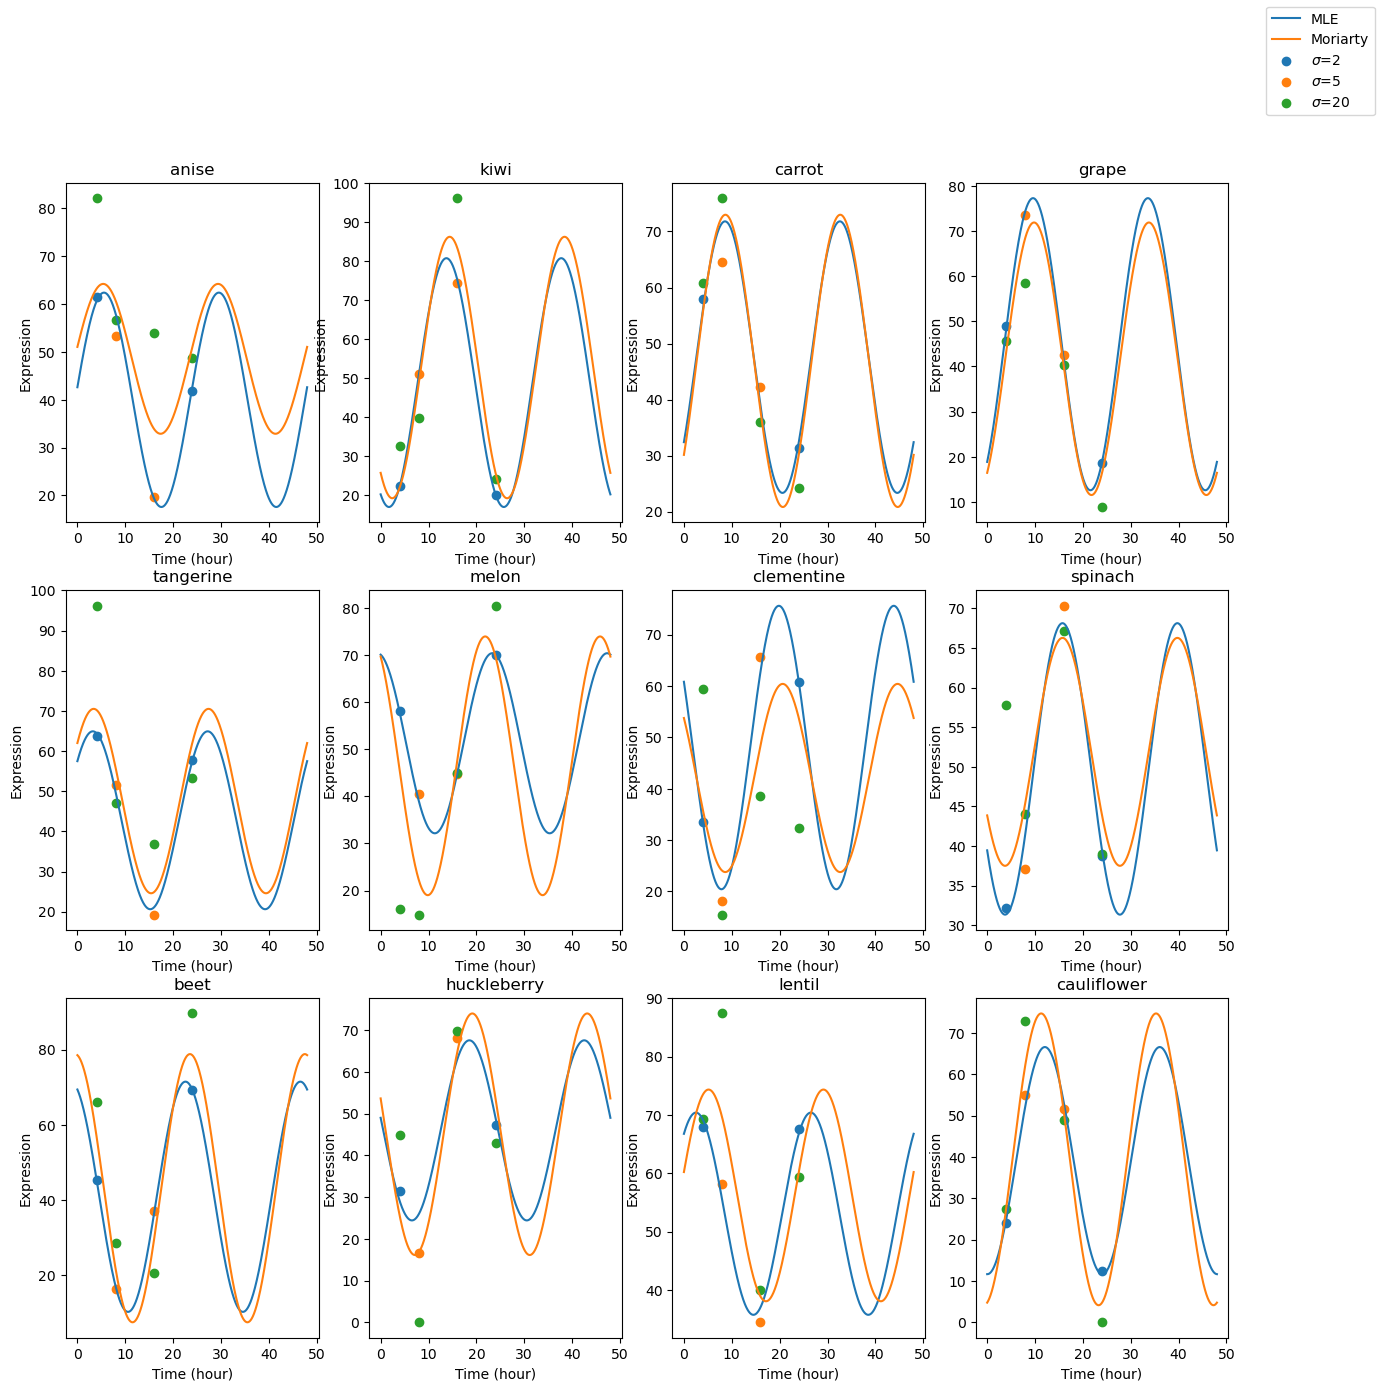

In [49]:
# Choosing a small time step
time_steps = np.linspace(0,48,1000)
plt.figure(figsize=(15,15))

# Plot expression levels for each genes
for i in range(len(gene_names)):
    plt.subplot(3,4,i+1)
    plt.title(gene_names[i])
    plt.scatter([time_points[j] for j in range(len(sigmas)) if sigmas[j] == 2],
                [data[i][j] for j in range(len(sigmas)) if sigmas[j] == 2], 
                label="$\sigma$=2")
    plt.scatter([time_points[j] for j in range(len(sigmas)) if sigmas[j] == 5],
                [data[i][j] for j in range(len(sigmas)) if sigmas[j] == 5],
                label = "$\sigma$=5")
    plt.scatter([time_points[j] for j in range(len(sigmas)) if sigmas[j] == 20],
                [data[i][j] for j in range(len(sigmas)) if sigmas[j] == 20], 
                label="$\sigma$=20")
    plt.xlabel("Time (hour)")
    plt.ylabel("Expression")
    plt.plot(time_steps,get_ex_expr(*res_params[i], time_steps),label="MLE")
    plt.plot(time_steps,get_ex_expr(*moriarty_params[i], time_steps), 
            label="Moriarty")
plt.figlegend(["MLE", "Moriarty","$\sigma$=2","$\sigma$=5", "$\sigma$=20"])
plt.show()


We can see that, from the plot, the expression level curve with MLE generated parameters best fits the data with the lowest variance 2, and with increased variance, the fitting is not as good, which is expected. The curve also fits the data much better than the curve generated by Moriarty.